## Gold Prediction model with Tensorflow 

We're going to predict prices of Gold using a Transformer neural network

## Import data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os 
from sklearn.preprocessing import MinMaxScaler
import yfinance as yf
import datetime
import tempfile
import requests

In [2]:
SEQ_LEN = 60  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 5000  # how many passes through our data
BATCH_SIZE = 1024  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.

In [3]:
def get_start_date(end_date, days):
    '''
    get the start date from end date
    '''
    return end_date - datetime.timedelta(days=days)



#define the ticker symbol
tickerSymbol = 'GLD'

#get data on this ticker
tickerData = yf.Ticker(tickerSymbol)

#get the historical prices for this ticker
end_date = datetime.date.today()
start_date = get_start_date(end_date, SEQ_LEN)
df = tickerData.history(period='1d', start=start_date, end=end_date)
df.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2020-11-03,178.949997,179.389999,178.300003,178.919998,7577200,0,0
2020-11-04,178.929993,179.190002,177.660004,178.820007,11117300,0,0
2020-11-05,181.000000,183.289993,180.970001,182.929993,16102800,0,0
2020-11-06,183.399994,183.529999,182.190002,183.190002,10378300,0,0
2020-11-09,176.419998,176.449997,173.639999,175.080002,29800700,0,0


In [4]:
# I got it from https://finance.yahoo.com/quote/GE/history?p=GE&.tsrc=fin-srch

#df = pd.read_csv('2- ge.us.txt',delimiter=',',usecols=['Date','Open','High','Low','Close', 'Volume'])

#define the ticker symbol
tickerSymbol = 'GLD'

#get data on this ticker
df = yf.download(tickerSymbol, start="2005-01-01", end="2020-10-30")[['Open','High','Low','Close', 'Volume']]

[*********************100%***********************]  1 of 1 completed


In [5]:
# Sort DataFrame by date
df = df.reset_index().sort_values('Date')

# Double check the result
df.head()

,Date,Open,High,Low,Close,Volume
0,2004-12-31,43.849998,43.939999,43.730000,43.799999,531600
1,2005-01-03,42.980000,43.169998,42.740002,43.020000,4750400
2,2005-01-04,42.799999,42.910000,42.459999,42.740002,3456800
3,2005-01-05,42.750000,42.880001,42.599998,42.669998,2033600
4,2005-01-06,42.480000,42.560001,42.070000,42.150002,2556400


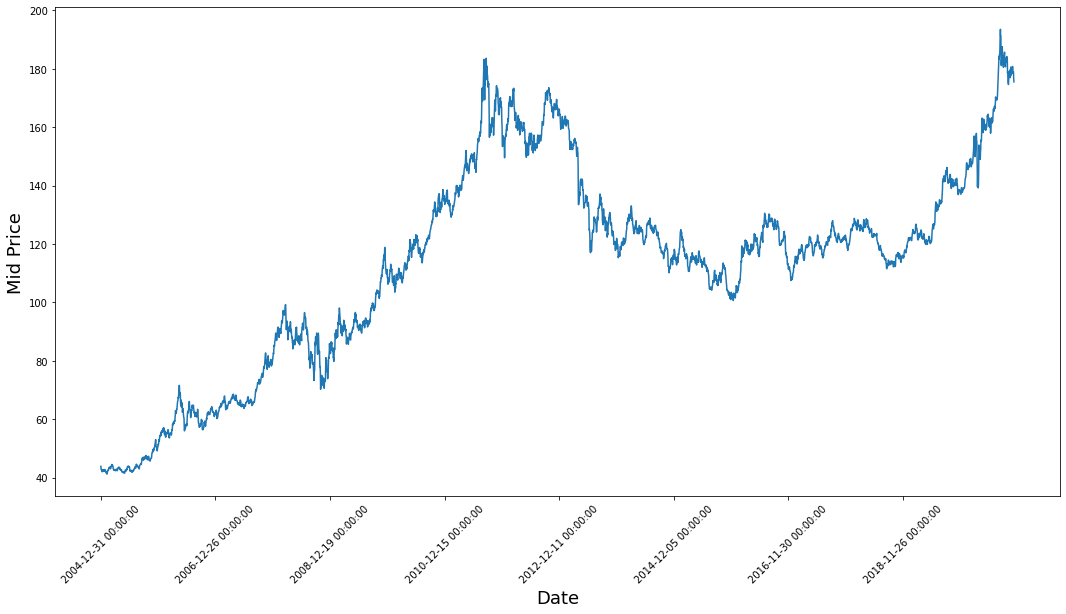

In [6]:
plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),(df['Low']+df['High'])/2.0)
plt.xticks(range(0,df.shape[0],500),df['Date'].loc[::500],rotation=45)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Mid Price',fontsize=18)
plt.show()

## Data preprocessing 

In [7]:
df['mid'] = (df['Low']+df['High'])/2.0

In [8]:
RATIO_TO_PREDICT = "mid"

In [9]:
def classify(current, future):
    if float(future) > float(current):
        return 1
    else:
        return 0

In [10]:
df['future'] = df[RATIO_TO_PREDICT].shift(-FUTURE_PERIOD_PREDICT)

In [11]:
df['target'] = list(map(classify, df[RATIO_TO_PREDICT], df['future']))

In [12]:
df.head()

,Date,Open,High,Low,Close,Volume,mid,future,target
0,2004-12-31,43.849998,43.939999,43.730000,43.799999,531600,43.834999,42.955000,0
1,2005-01-03,42.980000,43.169998,42.740002,43.020000,4750400,42.955000,42.684999,0
2,2005-01-04,42.799999,42.910000,42.459999,42.740002,3456800,42.684999,42.740000,1
3,2005-01-05,42.750000,42.880001,42.599998,42.669998,2033600,42.740000,42.315001,0
4,2005-01-06,42.480000,42.560001,42.070000,42.150002,2556400,42.315001,42.045000,0


In [13]:
df.tail()

,Date,Open,High,Low,Close,Volume,mid,future,target
3981,2020-10-23,179.089996,179.199997,177.759995,178.639999,5919300,178.479996,178.680000,1
3982,2020-10-26,178.750000,179.139999,178.220001,178.550003,5105100,178.680000,178.969994,1
3983,2020-10-27,178.710007,179.429993,178.509995,179.020004,5826900,178.969994,176.145004,0
3984,2020-10-28,176.449997,176.850006,175.440002,176.130005,11734100,176.145004,175.485001,0
3985,2020-10-29,175.020004,176.139999,174.830002,175.399994,8474500,175.485001,NaN,0


In [14]:
times = sorted(df.index.values)  # get the times
last_10pct = sorted(df.index.values)[-int(0.1*len(times))]  # get the last 10% of the times
last_20pct = sorted(df.index.values)[-int(0.2*len(times))]  # get the last 20% of the times

test_df = df[(df.index >= last_10pct)]
validation_df = df[(df.index >= last_20pct) & (df.index < last_10pct)]  
train_df = df[(df.index < last_20pct)]  # now the train_df is all the data up to the last 20%

In [15]:
from collections import deque
import numpy as np
import random

In [16]:
train_df.drop(columns=["Date", "future", 'Open', 'High', 'Low', 'Close', 'Volume'], inplace=True)
validation_df.drop(columns=["Date", "future", 'Open', 'High', 'Low', 'Close', 'Volume'], inplace=True)
test_df.drop(columns=["Date", "future", 'Open', 'High', 'Low', 'Close', 'Volume'], inplace=True)# don't need this anymore.

/Users/dachkovski/Library/Python/3.8/lib/python/site-packages/pandas/core/frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [17]:
train_df.head()

,mid,target
0,43.834999,0
1,42.955000,0
2,42.684999,1
3,42.740000,0
4,42.315001,0


In [18]:
train_split = train_df[RATIO_TO_PREDICT].values
valid_split = validation_df[RATIO_TO_PREDICT].values
test_split = test_df[RATIO_TO_PREDICT].values

In [19]:
train_data = train_split.reshape(-1,1).copy()
valid_data = valid_split.reshape(-1,1).copy()
test_data = test_split.reshape(-1,1).copy()

In [20]:
# Train the Scaler with data and smooth data
scaler_train = MinMaxScaler()
smoothing_window_size = SEQ_LEN
for di in range(0,len(train_data),smoothing_window_size):
    scaler_train.fit(train_data[di:di+smoothing_window_size])
    train_data[di:di+smoothing_window_size] = scaler_train.transform(train_data[di:di+smoothing_window_size])
    
train_data = train_data.reshape(-1)

In [21]:
scaler_test = MinMaxScaler()
smoothing_window_size = SEQ_LEN
for di in range(0,len(test_data),smoothing_window_size):
    scaler_test.fit(test_data[di:di+smoothing_window_size])
    test_data[di:di+smoothing_window_size] = scaler_test.transform(test_data[di:di+smoothing_window_size])
test_data = test_data.reshape(-1)

In [22]:
scaler_valid = MinMaxScaler()
smoothing_window_size = SEQ_LEN
for di in range(0,len(valid_data),smoothing_window_size):
    scaler_valid.fit(valid_data[di:di+smoothing_window_size])
    valid_data[di:di+smoothing_window_size] = scaler_valid.transform(valid_data[di:di+smoothing_window_size])
valid_data = valid_data.reshape(-1)

In [23]:
# Reshape both train and test data
#test_data = scaler1.transform(test_data).reshape(-1)
#valid_data = scaler1.transform(valid_data).reshape(-1)

In [24]:
# Used for visualization and test purposes
all_mid_data = np.concatenate([train_data,valid_data, test_data],axis=0)

In [25]:
X_train = []
y_train = []
for i in range(SEQ_LEN, len(train_data)):
    X_train.append(train_data[i-SEQ_LEN:i])
    y_train.append(train_data[i + (FUTURE_PERIOD_PREDICT-1)])
X_train, y_train = np.array(X_train), np.array(y_train)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [26]:
X_valid = []
y_valid = []
for i in range(SEQ_LEN, len(valid_data)):
    X_valid.append(valid_data[i-SEQ_LEN:i])
    y_valid.append(valid_data[i+(FUTURE_PERIOD_PREDICT-1)])
X_valid, y_valid = np.array(X_valid), np.array(y_valid)

X_valid = np.reshape(X_valid, (X_valid.shape[0], X_valid.shape[1], 1))

In [27]:
X_test = []
y_test = []
for i in range(SEQ_LEN, len(test_data)):
    X_test.append(test_data[i-SEQ_LEN:i])
    y_test.append(test_data[i+(FUTURE_PERIOD_PREDICT-1)])
    
X_test, y_test = np.array(X_test), np.array(y_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [28]:
y_train.shape

(3129,)

In [29]:
y_valid.shape

(339,)

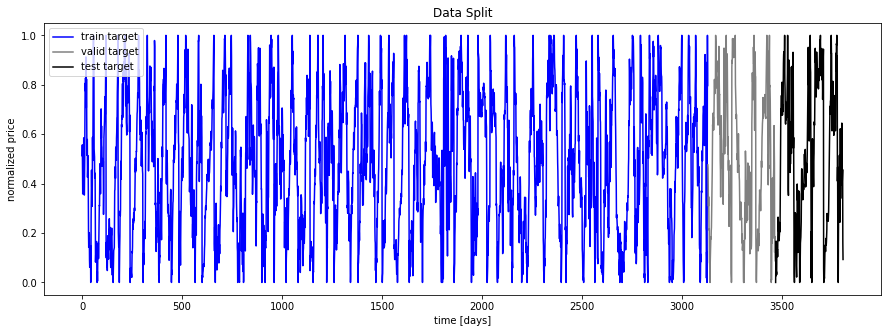

In [30]:
## show predictions
plt.figure(figsize=(15, 5))

plt.plot(np.arange(y_train.shape[0]), y_train, color='blue', label='train target')

plt.plot(np.arange(y_train.shape[0], y_train.shape[0]+y_valid.shape[0]), y_valid,
         color='gray', label='valid target')

plt.plot(np.arange(y_train.shape[0]+y_valid.shape[0],
                   y_train.shape[0]+y_valid.shape[0]+y_test.shape[0]),
         y_test, color='black', label='test target')


plt.title('Data Split')
plt.xlabel('time [days]')
plt.ylabel('normalized price')
plt.legend(loc='best');

In [31]:
import time

NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

## Model Build (Transformer)

In [32]:
# https://www.kaggle.com/shujian/transformer-with-lstm

import random, os, sys
import numpy as np
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.initializers import *
import tensorflow as tf
from tensorflow.python.keras.layers import Layer
from tensorflow.keras import backend as K

try:
    from dataloader import TokenList, pad_to_longest
    # for transformer
except: pass



embed_size = 60

class LayerNormalization(Layer):
    def __init__(self, eps=1e-6, **kwargs):
        self.eps = eps
        super(LayerNormalization, self).__init__(**kwargs)
    def build(self, input_shape):
        self.gamma = self.add_weight(name='gamma', shape=input_shape[-1:],
                                     initializer=Ones(), trainable=True)
        self.beta = self.add_weight(name='beta', shape=input_shape[-1:],
                                    initializer=Zeros(), trainable=True)
        super(LayerNormalization, self).build(input_shape)
    def call(self, x):
        mean = K.mean(x, axis=-1, keepdims=True)
        std = K.std(x, axis=-1, keepdims=True)
        return self.gamma * (x - mean) / (std + self.eps) + self.beta
    def compute_output_shape(self, input_shape):
        return input_shape

class ScaledDotProductAttention():
    def __name__(): # Fix for Tensorflow 
        pass
    def __init__(self, d_model, attn_dropout=0.1):
        self.temper = np.sqrt(d_model)
        self.dropout = Dropout(attn_dropout)
    def __call__(self, q, k, v, mask):
        attn = Lambda(lambda x:K.batch_dot(x[0],x[1],axes=[2,2])/self.temper)([q, k])
        if mask is not None:
            mmask = Lambda(lambda x:(-1e+10)*(1-x))(mask)
            attn = Add()([attn, mmask])
        attn = Activation('softmax')(attn)
        attn = self.dropout(attn)
        output = Lambda(lambda x:K.batch_dot(x[0], x[1]))([attn, v])
        return output, attn

class MultiHeadAttention():
    # mode 0 - big martixes, faster; mode 1 - more clear implementation
    def __init__(self, n_head, d_model, d_k, d_v, dropout, mode=0, use_norm=True):
        self.mode = mode
        self.n_head = n_head
        self.d_k = d_k
        self.d_v = d_v
        self.dropout = dropout
        if mode == 0:
            self.qs_layer = Dense(n_head*d_k, use_bias=False)
            self.ks_layer = Dense(n_head*d_k, use_bias=False)
            self.vs_layer = Dense(n_head*d_v, use_bias=False)
        elif mode == 1:
            self.qs_layers = []
            self.ks_layers = []
            self.vs_layers = []
            for _ in range(n_head):
                self.qs_layers.append(TimeDistributed(Dense(d_k, use_bias=False)))
                self.ks_layers.append(TimeDistributed(Dense(d_k, use_bias=False)))
                self.vs_layers.append(TimeDistributed(Dense(d_v, use_bias=False)))
        self.attention = ScaledDotProductAttention(d_model)
        self.layer_norm = LayerNormalization() if use_norm else None
        self.w_o = TimeDistributed(Dense(d_model))

    def __call__(self, q, k, v, mask=None):
        d_k, d_v = self.d_k, self.d_v
        n_head = self.n_head

        if self.mode == 0:
            qs = self.qs_layer(q)  # [batch_size, len_q, n_head*d_k]
            ks = self.ks_layer(k)
            vs = self.vs_layer(v)

            def reshape1(x):
                s = tf.shape(x)   # [batch_size, len_q, n_head * d_k]
                x = tf.reshape(x, [s[0], s[1], n_head, d_k])
                x = tf.transpose(x, [2, 0, 1, 3])  
                x = tf.reshape(x, [-1, s[1], d_k])  # [n_head * batch_size, len_q, d_k]
                return x
            qs = Lambda(reshape1)(qs)
            ks = Lambda(reshape1)(ks)
            vs = Lambda(reshape1)(vs)

            if mask is not None:
                mask = Lambda(lambda x:K.repeat_elements(x, n_head, 0))(mask)
            head, attn = self.attention(qs, ks, vs, mask=mask)  
                
            def reshape2(x):
                s = tf.shape(x)   # [n_head * batch_size, len_v, d_v]
                x = tf.reshape(x, [n_head, -1, s[1], s[2]]) 
                x = tf.transpose(x, [1, 2, 0, 3])
                x = tf.reshape(x, [-1, s[1], n_head*d_v])  # [batch_size, len_v, n_head * d_v]
                return x
            head = Lambda(reshape2)(head)
        elif self.mode == 1:
            heads = []; attns = []
            for i in range(n_head):
                qs = self.qs_layers[i](q)   
                ks = self.ks_layers[i](k) 
                vs = self.vs_layers[i](v) 
                head, attn = self.attention(qs, ks, vs, mask)
                heads.append(head); attns.append(attn)
            head = Concatenate()(heads) if n_head > 1 else heads[0]
            attn = Concatenate()(attns) if n_head > 1 else attns[0]

        outputs = self.w_o(head)
        outputs = Dropout(self.dropout)(outputs)
        if not self.layer_norm: return outputs, attn
        # outputs = Add()([outputs, q]) # sl: fix
        return self.layer_norm(outputs), attn

class PositionwiseFeedForward():
    def __init__(self, d_hid, d_inner_hid, dropout=0.1):
        self.w_1 = Conv1D(d_inner_hid, 1, activation='relu')
        self.w_2 = Conv1D(d_hid, 1)
        self.layer_norm = LayerNormalization()
        self.dropout = Dropout(dropout)
    def __call__(self, x):
        output = self.w_1(x) 
        output = self.w_2(output)
        output = self.dropout(output)
        output = Add()([output, x])
        return self.layer_norm(output)

class EncoderLayer():
    def __init__(self, d_model, d_inner_hid, n_head, d_k, d_v, dropout=0.1):
        self.self_att_layer = MultiHeadAttention(n_head, d_model, d_k, d_v, dropout=dropout)
        self.pos_ffn_layer  = PositionwiseFeedForward(d_model, d_inner_hid, dropout=dropout)
    def __call__(self, enc_input, mask=None):
        output, slf_attn = self.self_att_layer(enc_input, enc_input, enc_input, mask=mask)
        output = self.pos_ffn_layer(output)
        return output, slf_attn


def GetPosEncodingMatrix(max_len, d_emb):
    pos_enc = np.array([
        [pos / np.power(10000, 2 * (j // 2) / d_emb) for j in range(d_emb)] 
        if pos != 0 else np.zeros(d_emb) 
            for pos in range(max_len)
            ])
    pos_enc[1:, 0::2] = np.sin(pos_enc[1:, 0::2]) # dim 2i
    pos_enc[1:, 1::2] = np.cos(pos_enc[1:, 1::2]) # dim 2i+1
    return pos_enc

def GetPadMask(q, k):
    ones = K.expand_dims(K.ones_like(q, 'float32'), -1)
    mask = K.cast(K.expand_dims(K.not_equal(k, 0), 1), 'float32')
    mask = K.batch_dot(ones, mask, axes=[2,1])
    return mask

def GetSubMask(s):
    len_s = tf.shape(s)[1]
    bs = tf.shape(s)[:1]
    mask = K.cumsum(tf.eye(len_s, batch_shape=bs), 1)
    return mask

class Transformer():
    def __init__(self, len_limit, embedding_matrix, d_model=embed_size, \
              d_inner_hid=512, n_head=10, d_k=64, d_v=64, layers=2, dropout=0.1, \
              share_word_emb=False, **kwargs):
        self.name = 'Transformer'
        self.len_limit = len_limit
        self.src_loc_info = False # True # sl: fix later
        self.d_model = d_model
        self.decode_model = None
        d_emb = d_model

        pos_emb = Embedding(len_limit, d_emb, trainable=False, \
                            weights=[GetPosEncodingMatrix(len_limit, d_emb)])

        i_word_emb = Embedding(max_features, d_emb, weights=[embedding_matrix]) # Add Kaggle provided embedding here

        self.encoder = Encoder(d_model, d_inner_hid, n_head, d_k, d_v, layers, dropout, \
                               word_emb=i_word_emb, pos_emb=pos_emb)

        
    def get_pos_seq(self, x):
        mask = K.cast(K.not_equal(x, 0), 'int32')
        pos = K.cumsum(K.ones_like(x, 'int32'), 1)
        return pos * mask

    def compile(self, active_layers=999):
        src_seq_input = Input(shape=(None, ))
        x = Embedding(max_features, embed_size, weights=[embedding_matrix])(src_seq_input)
        
        # LSTM before attention layers
        x = Bidirectional(LSTM(128, return_sequences=True))(x)
        x = Bidirectional(LSTM(64, return_sequences=True))(x) 
        
        x, slf_attn = MultiHeadAttention(n_head=3, d_model=300, d_k=64, d_v=64, dropout=0.1)(x, x, x)
        
        avg_pool = GlobalAveragePooling1D()(x)
        max_pool = GlobalMaxPooling1D()(x)
        conc = concatenate([avg_pool, max_pool])
        conc = Dense(64, activation="relu")(conc)
        x = Dense(1, activation="sigmoid")(conc)   
        
        #self.model = keras.models.Model(inputs=src_seq_input, outputs=x)
        self.model = Model(inputs=src_seq_input, outputs=x)
        self.model.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics=['accuracy'])
        


In [33]:
# Fix for Tensorflow Model saving
def get_config(self):
    cfg = super().get_config()
    return cfg 

In [34]:
def build_model():
    inp = Input(shape = (SEQ_LEN, 1), name="keys")
    
    # LSTM before attention layers
    x = Bidirectional(LSTM(128, return_sequences=True))(inp)
    x = Bidirectional(LSTM(64, return_sequences=True))(x) 
        
    x, slf_attn = MultiHeadAttention(n_head=3, d_model=300, d_k=64, d_v=64, dropout=0.1)(x, x, x)
        
    avg_pool = GlobalAveragePooling1D()(x)
    max_pool = GlobalMaxPooling1D()(x)
    conc = concatenate([avg_pool, max_pool])
    conc = Dense(64, activation="relu")(conc)
    x = Dense(1, activation="sigmoid", name="keys_output")(conc)      

    model = Model(inputs = inp, outputs = x, name=NAME)
    model.compile(
        loss = "mean_squared_error", 
        #optimizer = Adam(lr = config["lr"], decay = config["lr_d"]), 
        optimizer = "adam")
    
    # Save entire model to a HDF5 file
    #model.save('my_model.h5')
    
    return model

In [35]:
multi_head = build_model()

In [36]:
multi_head.summary()

Model: "60-SEQ-1-PRED-1609699703"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
keys (InputLayer)               [(None, 60, 1)]      0                                            
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 60, 256)      133120      keys[0][0]                       
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 60, 128)      164352      bidirectional[0][0]              
__________________________________________________________________________________________________
dense (Dense)                   (None, 60, 192)      24576       bidirectional_1[0][0]            
___________________________________________________________________________

## Model Training

In [37]:
history = multi_head.fit(X_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=(X_valid, y_valid),
                    #callbacks = [checkpoint , lr_reduce]
             )

Epoch 1/10
4/4 [==============================] - 16s 2s/step - loss: 0.1903 - val_loss: 0.1349
Epoch 2/10
1/4 [======>.......................] - ETA: 8s - loss: 0.1684

KeyboardInterrupt: 

In [ ]:
# save model in simple tensorflow serving model folder
export_path = './backend/models/transformer/1'
tf.keras.models.save_model(
    multi_head,
    export_path,
    overwrite=True,     
    #include_optimizer=True,
    #save_format='tf',
    #signatures=None,
    #options=None
)

## Tests

#### API Test

In [ ]:
endpoint = "http://127.0.0.1:8500" # backend api
json_data = {"model_name": "default", "data": {"keys": [X_train[-1].tolist()]} }
result = requests.post(endpoint, json=json_data)
print(result.json())
pred_output = result.json()['keys_output'][0][0]
pred_output

#### Loss and Accuracy

In [ ]:
print(history.history.keys())
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
multi_head.predict(X_test)

In [ ]:
predicted_stock_price_multi_head = multi_head.predict(X_test)

In [ ]:
predicted_stock_price_multi_head = np.vstack((np.full((60,1), np.nan), predicted_stock_price_multi_head))

In [ ]:
df = pd.DataFrame({
          'day':np.arange(1,61),
          'actual': test_data[-61:-1].reshape(-1),
          'predicted': predicted_stock_price_multi_head[-61:-1].reshape(-1),
          'actual_shifted': test_data[-62:-2].reshape(-1),})

In [ ]:
df

In [ ]:
df['correct?'] = np.where(((df['actual'] > df['actual_shifted']) & (df['predicted'] > df['actual_shifted']))\
                          |((df['actual'] < df['actual_shifted']) & (df['predicted'] < df['actual_shifted'])), True, False)

In [ ]:
# accuracy
df['correct?'].mean().round(2)

#### Visuals

In [ ]:
plt.figure(figsize = (18,9))
plt.plot(test_data.reshape(-1, 1), color = 'black', label = 'Gold Price')
plt.plot(predicted_stock_price_multi_head, color = 'green', label = 'Predicted Gold Mid Price')
plt.title('Gold Scaled Actual and Prediction Mid Intraday Price', fontsize=30)
plt.xlabel('Days')
plt.ylabel('Gold Mid Price')
plt.legend(fontsize=18)
plt.show()

In [ ]:
plt.figure(figsize = (18,9))
plt.plot(np.arange(60), test_data[-60:], color = 'black', label = 'Gold Price')
plt.plot(61, predicted_stock_price_multi_head[-1], 'r+', color = 'red', markersize=12, label = 'Predicted Gold Mid Price', )
plt.title('Gold Mid Price Prediction for next day', fontsize=30)
plt.xlabel('Days')
plt.ylabel('Gold Mid Price')
plt.legend(fontsize=18)
plt.show()